# 1. Read cleaned transaction file

In [1]:
import pandas as pd 

# Read transaction cleaned file

transaction_data = pd.read_csv('transaction_data_cleaned.csv')
transaction_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19803 entries, 0 to 19802
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           19803 non-null  int64  
 1   product_id               19803 non-null  int64  
 2   customer_id              19803 non-null  int64  
 3   transaction_date         19803 non-null  object 
 4   online_order             19803 non-null  float64
 5   order_status             19803 non-null  object 
 6   brand                    19803 non-null  object 
 7   product_line             19803 non-null  object 
 8   product_class            19803 non-null  object 
 9   product_size             19803 non-null  object 
 10  list_price               19803 non-null  float64
 11  standard_cost            19803 non-null  float64
 12  product_first_sold_date  19803 non-null  float64
 13  profit                   19803 non-null  float64
dtypes: float64(5), int64(3

In [2]:
# Convert datetime object

import datetime

transaction_data['transaction_date'] = pd.to_datetime(transaction_data['transaction_date'])
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19803 entries, 0 to 19802
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           19803 non-null  int64         
 1   product_id               19803 non-null  int64         
 2   customer_id              19803 non-null  int64         
 3   transaction_date         19803 non-null  datetime64[ns]
 4   online_order             19803 non-null  float64       
 5   order_status             19803 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               19803 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

# 2. RFM analysis
- To calculate RFM score we need only Transaction data.
- We will use other data for deeper analysis later.

## 2.1 Calculating Recency

In [3]:
# Check type of transaction_date column
assert transaction_data['transaction_date'].dtype == 'datetime64[ns]'


In [4]:
# Define last purchase date in dataset as reference date 
ref_date = max(transaction_data['transaction_date']) 
print(ref_date)  # 30 Dec 2017

2017-12-30 00:00:00


In [5]:
# Find last transaction date of each customer

# First group the data with customer_id
grouped_customers = transaction_data.groupby('customer_id')

# for id, group in grouped_customers:  # Print and Check
#     print(id)
#     print(group.tail(1))  # Printing only top 2 rows of each group

In [6]:
# Aggregate rows with last transaction date in each group

recent_dates = grouped_customers.agg({'transaction_date': max})
print(recent_dates)


            transaction_date
customer_id                 
1                 2017-12-23
2                 2017-08-24
3                 2017-09-19
4                 2017-06-18
5                 2017-12-14
...                      ...
3497              2017-11-08
3498              2017-08-25
3499              2017-11-09
3500              2017-08-08
5034              2017-10-07

[3494 rows x 1 columns]


/var/folders/pj/jpdw695151g451wf0zdz5wm40000gp/T/ipykernel_77966/3100041893.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  recent_dates = grouped_customers.agg({'transaction_date': max})


In [7]:
# Rename column name
recent_dates.rename(columns={'transaction_date': 'last_purchase_date'}, inplace = True)
print(recent_dates)


            last_purchase_date
customer_id                   
1                   2017-12-23
2                   2017-08-24
3                   2017-09-19
4                   2017-06-18
5                   2017-12-14
...                        ...
3497                2017-11-08
3498                2017-08-25
3499                2017-11-09
3500                2017-08-08
5034                2017-10-07

[3494 rows x 1 columns]


In [8]:
# Calculate recency

recent_dates['recency'] = (ref_date - recent_dates['last_purchase_date']).dt.days  # Create new column with recency
                                                                                   # .dt.days will extract number out of days,
                                                                                   # e.g. '7 days' to '7'
recent_dates

,last_purchase_date,recency
customer_id,,
1,2017-12-23,7
2,2017-08-24,128
3,2017-09-19,102
4,2017-06-18,195
5,2017-12-14,16
...,...,...
3497,2017-11-08,52
3498,2017-08-25,127
3499,2017-11-09,51


In [9]:
# No need of last_purchase_date column now
recent_dates.drop(columns=['last_purchase_date'], inplace = True ) # This is our recency data


In [10]:
recency_data = recent_dates
recency_data.head()

,recency
customer_id,
1,7
2,128
3,102
4,195
5,16


## 2.2 Calculating Frequency

- For this we will calculate total number of transactions by each customer.

In [11]:
# Number of purcahses by each customer
frequency_data = grouped_customers.size().reset_index(name='frequency')  # reset name names the new column
frequency_data.head()

,customer_id,frequency
0,1,11
1,2,3
2,3,8
3,4,2
4,5,6


## 2.3 Calculating Monetary Value

In [12]:
monetary_data= grouped_customers.agg({'list_price': 'sum'})
monetary_data = monetary_data.rename(columns={'list_price':'monetary'})
monetary_data

,monetary
customer_id,
1,9084.45
2,4149.07
3,9888.23
4,1047.72
5,5903.20
...,...
3497,3744.07
3498,5177.06
3499,7673.48


## 2.4 Merging RFM data

In [13]:
# Merge recency, frequency, and monetary data on customer_id

rfm_data = recency_data.merge(frequency_data, on='customer_id')
rfm_data = rfm_data.merge(monetary_data, on='customer_id')
rfm_data

,customer_id,recency,frequency,monetary
0,1,7,11,9084.45
1,2,128,3,4149.07
2,3,102,8,9888.23
3,4,195,2,1047.72
4,5,16,6,5903.20
...,...,...,...,...
3489,3497,52,3,3744.07
3490,3498,127,6,5177.06
3491,3499,51,7,7673.48
3492,3500,144,6,4922.41


## 2.5 Find individual r, f, and m scores

In [14]:
# Define quantiles

quantiles = rfm_data[['recency', 'frequency', 'monetary']].quantile([0.2,0.4,0.6,0.8])
quantiles

,recency,frequency,monetary
0.2,14.0,4.0,3739.432
0.4,32.0,5.0,5246.158
0.6,58.0,6.0,6736.550
0.8,99.0,8.0,8692.952


In [15]:
# Define scoring function

# For recency: lower the recency, higher the score

from typing import Union, Dict

def recency_score(x: Union[float, int], quantiles: Dict[float, float]) -> int:
    if x <= quantiles[0.2]:
        return 5
    elif x <= quantiles[0.4]:
        return 4
    elif x <= quantiles[0.6]:
        return 3
    elif x <= quantiles[0.8]:
        return 2
    else:
        return 1
    
# For frequency and monetary: higher the frequency/monetary, higher the score
    
def f_and_m_score(x: Union[int, float], quantiles: Dict[float, float]) -> int:
    if x <= quantiles[0.2]:
        return 1
    elif x <= quantiles[0.4]:
        return 2
    elif x <= quantiles[0.6]:
        return 3
    elif x <= quantiles[0.8]:
        return 4
    else:
        return 5



In [16]:
# Score r, f, m

rfm_data['r_score'] = rfm_data['recency'].apply(lambda x: recency_score(x, quantiles['recency']))
rfm_data['f_score'] = rfm_data['frequency'].apply(lambda x: f_and_m_score(x, quantiles['frequency']))
rfm_data['m_score'] = rfm_data['monetary'].apply(lambda x: f_and_m_score(x, quantiles['monetary']))
rfm_data

,customer_id,recency,frequency,monetary,r_score,f_score,m_score
0,1,7,11,9084.45,5,5,5
1,2,128,3,4149.07,1,1,2
2,3,102,8,9888.23,1,4,5
3,4,195,2,1047.72,1,1,1
4,5,16,6,5903.20,4,3,3
...,...,...,...,...,...,...,...
3489,3497,52,3,3744.07,3,1,2
3490,3498,127,6,5177.06,1,3,2
3491,3499,51,7,7673.48,3,4,4
3492,3500,144,6,4922.41,1,3,2


## 2.6 Create a single rfm score

- RFM score is a three-digit number where each digit represents one component of the RFM model. For example, an RFM score of 543 means a recency score of 5, a frequency score of 4, and a monetary score of 3.

- The total RFM score is typically calculated as:

$$rfm\_score = 100× r\_score +10× f\_score + m\_score$$

In [17]:
rfm_data['rfm_score'] = rfm_data['r_score']*100 + rfm_data['f_score']*10 + rfm_data['m_score']
rfm_data

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,1,7,11,9084.45,5,5,5,555
1,2,128,3,4149.07,1,1,2,112
2,3,102,8,9888.23,1,4,5,145
3,4,195,2,1047.72,1,1,1,111
4,5,16,6,5903.20,4,3,3,433
...,...,...,...,...,...,...,...,...
3489,3497,52,3,3744.07,3,1,2,312
3490,3498,127,6,5177.06,1,3,2,132
3491,3499,51,7,7673.48,3,4,4,344
3492,3500,144,6,4922.41,1,3,2,132


## 2.7 Segment customers
We will divide our customers into 
1. Champions: rfm = 5 5 5
> - Frequently purchase, spend a lot, and have purchased recently.
> - Reward with exclusive offers, loyalty programs, or VIP treatment

2. Loyal Customers: rfm = _ 5 5
> - Regular purchasers who spend a lot but may not have purchased recently.
> - Engage with loyalty rewards and personalized offers.

3. Potential Loyalists = all>= 4
> - Purchase regularly and spend reasonably well but might not have purchased recently.
> - Increase engagement to boost spending and recency.

4. New Customers = 5 _ _
> - Recent customers with moderate spending and frequency.
> - Welcome campaigns, introductory offers, and encourage repeat purchases.

5. At Risk = r<=2 f>=4 m>=4
> - Used to purchase frequently and spend well but haven’t purchased recently.
> - Target with win-back campaigns or special offers to re-engage

6. Lost Customers = r <= 2 _ _ 
> - Inactive customers who used to spend but are no longer engaging.
> - Consider reactivation strategies or marketing experiments to determine if they can be re-engaged.


In [18]:
rfm_data

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,1,7,11,9084.45,5,5,5,555
1,2,128,3,4149.07,1,1,2,112
2,3,102,8,9888.23,1,4,5,145
3,4,195,2,1047.72,1,1,1,111
4,5,16,6,5903.20,4,3,3,433
...,...,...,...,...,...,...,...,...
3489,3497,52,3,3744.07,3,1,2,312
3490,3498,127,6,5177.06,1,3,2,132
3491,3499,51,7,7673.48,3,4,4,344
3492,3500,144,6,4922.41,1,3,2,132


In [19]:
# Define Segmentation function

def segments(row: pd.Series) -> str:
    r: int = row['r_score']
    f: int = row['f_score']
    m: int = row['m_score']

    if r == 5 and f == 5 and m == 5:
        return 'Champions'
    elif f == 5 and m == 5:
        return 'Loyal Customers'
    elif r >= 4 and f >= 4 and m >= 4:
        return 'Potential Loyalists'
    elif r == 5:
        return 'New Customers'
    elif r <=2 and f >= 4 and m >= 4:
        return ' At Risk'
    elif r <=2:
        return 'Lost Customers'
    else: 
        return 'Average Customers'


In [20]:
# Apply Segmentation on columns (axis =1)
rfm_data['Segment'] = rfm_data.apply(segments, axis = 1)


In [21]:
rfm_data.head(5)

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,Segment
0,1,7,11,9084.45,5,5,5,555,Champions
1,2,128,3,4149.07,1,1,2,112,Lost Customers
2,3,102,8,9888.23,1,4,5,145,At Risk
3,4,195,2,1047.72,1,1,1,111,Lost Customers
4,5,16,6,5903.20,4,3,3,433,Average Customers


# 3. Export csv

In [22]:
rfm_data.to_csv('rfm_data.csv', index=False)

# RFM analysis

In [23]:
rfm_data

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,Segment
0,1,7,11,9084.45,5,5,5,555,Champions
1,2,128,3,4149.07,1,1,2,112,Lost Customers
2,3,102,8,9888.23,1,4,5,145,At Risk
3,4,195,2,1047.72,1,1,1,111,Lost Customers
4,5,16,6,5903.20,4,3,3,433,Average Customers
...,...,...,...,...,...,...,...,...,...
3489,3497,52,3,3744.07,3,1,2,312,Average Customers
3490,3498,127,6,5177.06,1,3,2,132,Lost Customers
3491,3499,51,7,7673.48,3,4,4,344,Average Customers
3492,3500,144,6,4922.41,1,3,2,132,Lost Customers


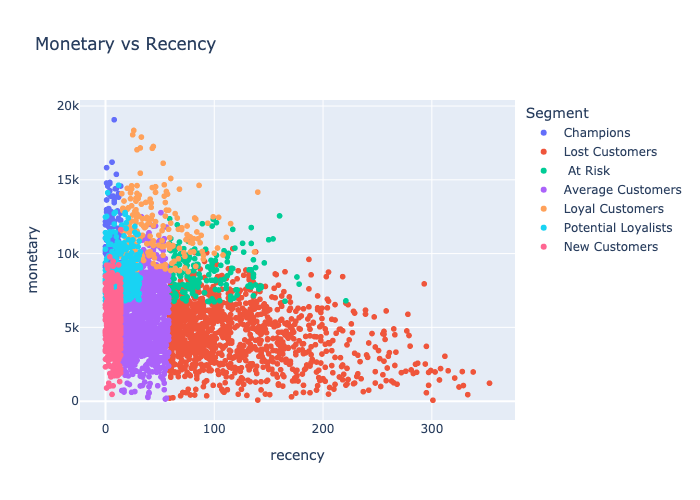

In [29]:
import plotly.express as px
import pandas as pd
import plotly.io as pio
from IPython.display import Image

# Example DataFrame
data = rfm_data
df = pd.DataFrame(data)

# Scatter plot for monetary vs recency
fig = px.scatter(df, x='recency', y='monetary', color='Segment',
                 title='Monetary vs Recency',
                 size_max=30)

# Show plot
# fig.show()   # This will not render plotly image in Github ipynb,
               # Save image as static one, then display the image 

# Save the figure as a static image
pio.write_image(fig, 'monetary_vs_recency.png')

# Display the image in the notebook

Image('monetary_vs_recency.png')


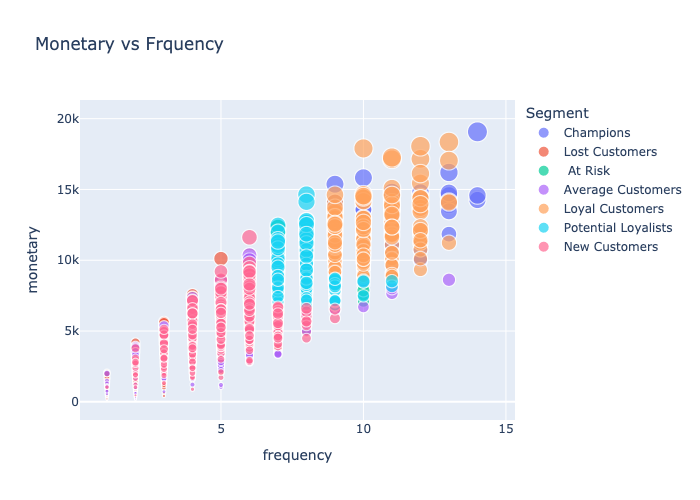

In [30]:
import plotly.express as px
import pandas as pd

# Example DataFrame
data = rfm_data
df = pd.DataFrame(data)

# Scatter plot for monetary vs frequency
fig = px.scatter(df, x='frequency', y='monetary', color='Segment',
                 title='Monetary vs Frquency',
                 size = 'monetary',
                 size_max=20)

# Show plot
# fig.show()

# Save the figure as a static image
pio.write_image(fig, 'monetary_vs_frequency.png')

# Display the image in the notebook

Image('monetary_vs_frequency.png')

